# Optimal execution of portfolio transactions - Numerical simulation

## Librairies importation

In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Model parameters

In [2]:
print("Optimal execution of portfolio liquidation")
print("Almgren-Chriss model")

T = 5 # 5 days
X = 10**6 # initial holding
S0 = 50 # initial stock price
N = 100 # number of time periods
sigma = 1 # 30% annual volatility (daily volatility)

eps = 0.0625 # bid-ask spread
gamma = 2.5e-7 # daily volume 5 million shares
eta = 2.5e-6 # impact at 1% of market
lambda_u = 1e-6 # Static holdings 11,000 shares


Optimal execution of portfolio liquidation
Almgren-Chriss model


## The trading model

In [3]:
# Market simulation - optimal execution of portfolio liquidation (Almgren-Chriss model)

tho = T/N # time interval
time = tho*np.arange(N+1) # time points

def reset(a):
    for i in range(len(a)):
        a[i] = 0

def fill_nk(xk):
    nk = np.zeros(N)
    for i in range(1,N+1):
        nk[i-1] = xk[i-1] - xk[i]
    return nk

def fill_xk(nk):
    xk = np.zeros(N+1)
    xk[0] = X
    for i in range(1,N):
        xk[i] = xk[i-1] - nk[i-1]
    return xk

## Price dynamics

In [4]:

def permanent_impact(n):
    return gamma*n

def temporary_impact(n):
    return eps*np.sign(n) + eta*n


def fill_Sk(xk):
    Sk = np.zeros(N+1)
    epss = np.random.normal(0,1,N)
    Sk[0] = S0
    for i in range(1,N+1):
        Sk[i] = S0 + sigma*np.sqrt(tho)*np.sum(epss[:i]) - gamma*(X - xk[i])
    return Sk

def fill_Sk_tilde(Sk, nk):
    Sk_tilde = np.zeros(N)
    for i in range(N):
        Sk_tilde[i] = Sk[i] - temporary_impact(nk[i]/tho)
    return Sk_tilde


## Market simulation

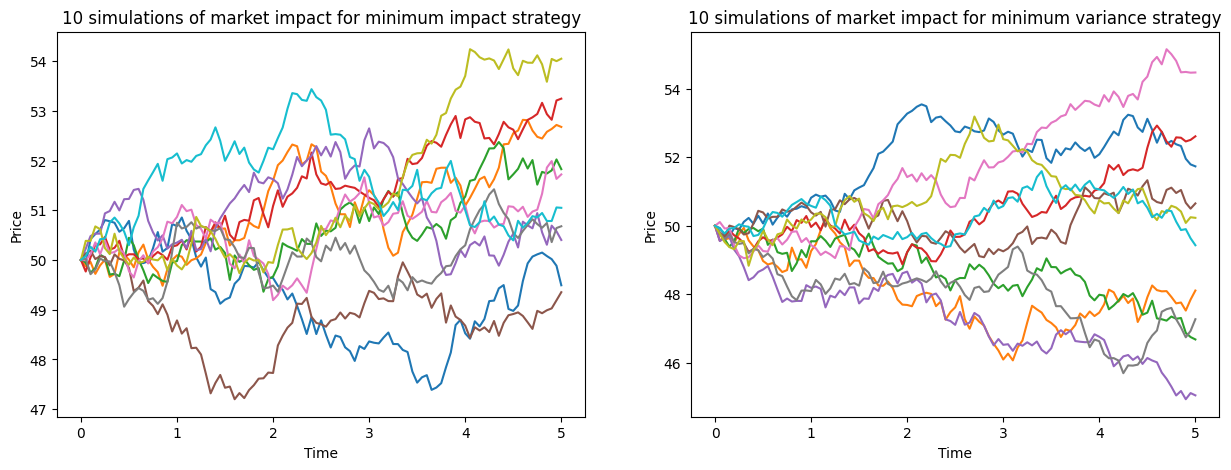

In [5]:
# Market simulation for minimum impact strategy
nk = np.zeros(N)
for i in range(N):
    nk[i] = X/N

xk = fill_xk(nk)

# 1000 simulations
n = 10
plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
plt.title(f"{n} simulations of market impact for minimum impact strategy")
plt.xlabel("Time")
plt.ylabel("Price")
for i in range(n):
    Sk = fill_Sk(xk)
    plt.plot(time,Sk, label=f"Simulation {i}")

nk[0] = X
for i in range(1,N):
    nk[i] = 0

xk = fill_xk(nk)
plt.subplot(1,2,2)
plt.title(f"{n} simulations of market impact for minimum variance strategy")
plt.xlabel("Time")
plt.ylabel("Price")

for i in range(n):
    Sk = fill_Sk(xk)
    plt.plot(time ,Sk, label=f"Simulation {i}")

plt.show()


## Optimal trajectories

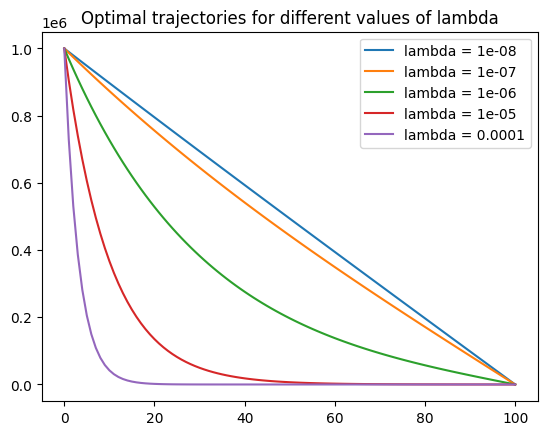

In [6]:
def eta_tilde():
    return eta - .5*gamma*tho

def kappa(lambda_, sig = sigma):
    return np.sqrt( (lambda_*sig**2)/ eta_tilde())    

# Optimal trajectories

def optimal_x(lambda_=lambda_u,sig = sigma):
    x = np.zeros(N+1)

    k = kappa(lambda_, sig)
    for i in range(N+1):
        x[i] = X* np.sinh(k*(T - i*tho))/np.sinh(k*T)
    return x

# Let's plot different optimal trajectories for different values of lambda_u
lambda_values = [ 1e-8, 1e-7, 1e-6, 1e-5, .0001]
plt.figure()
for l in lambda_values:
    plt.plot(optimal_x(lambda_=l), label=f"lambda = {l}")
plt.title("Optimal trajectories for different values of lambda")
plt.legend()
plt.show()

In [7]:
# Plot optimal execution strategies for different values of lambda_u


def shortfall_prime(lambda_ = lambda_u,sig = sigma):
    xk = optimal_x(lambda_, sig)
    nk = fill_nk(xk)
    Sk = fill_Sk(xk)
    Sk_tilde = fill_Sk_tilde(Sk, nk)

    return X*S0 - np.dot(nk, Sk_tilde)
    

sigmas = np.linspace(0.5,2.5,50)
utilities = np.zeros(len(sigmas))

n = 10000 # number of simulations
sf = np.zeros(n)

for index, s in enumerate(sigmas):
    reset(sf)
    for i in range(n):
        sf[i] = shortfall_prime(sig=s)
    utilities[index] = np.mean(sf) + lambda_u*np.var(sf)



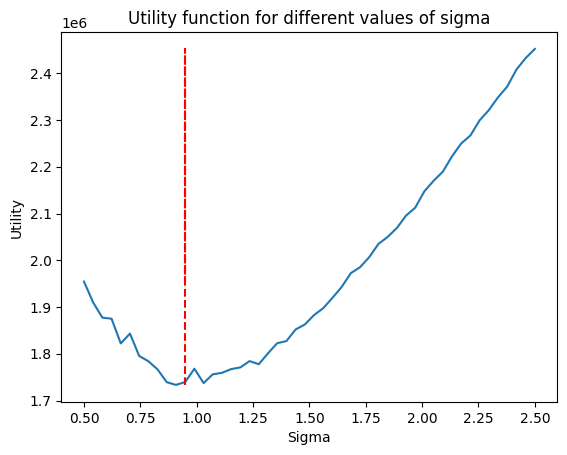

In [8]:
plt.figure()
plt.plot(sigmas, utilities)
plt.plot(0.95*np.array([1,1,1]), [min(utilities), max(utilities), utilities[0]], 'r--', label="sigma = 1")
plt.title("Utility function for different values of sigma")
plt.xlabel("Sigma")
plt.ylabel("Utility")
plt.show()